In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

SEED = 13
np.random.seed(SEED)

# Input

In [3]:
df = pd.read_csv('kaggle-digit-train-sample.csv')

In [4]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(1400, 785)

In [6]:
df.isna().sum().sum()

0

In [7]:
df.duplicated().sum()

0

In [93]:
X = df.drop(['label'],axis=1)
y = df['label'].ravel()

In [68]:
def plot_random_images_of_each_label():
    f,ax = plt.subplots(3,4,figsize=(15,15))
    ax = ax.ravel()
    for i in range(10):
        index = np.random.choice(X[df['label']==i].index,1)[0]
        ax[i].imshow(X.loc[index,:].values.reshape((28,28)))
        ax[i].set_title(f'Image:{index}')
        ax[i].set_xlabel(f'Label: {i}',size='x-large')

    f.delaxes(ax[-1])
    f.delaxes(ax[-2])

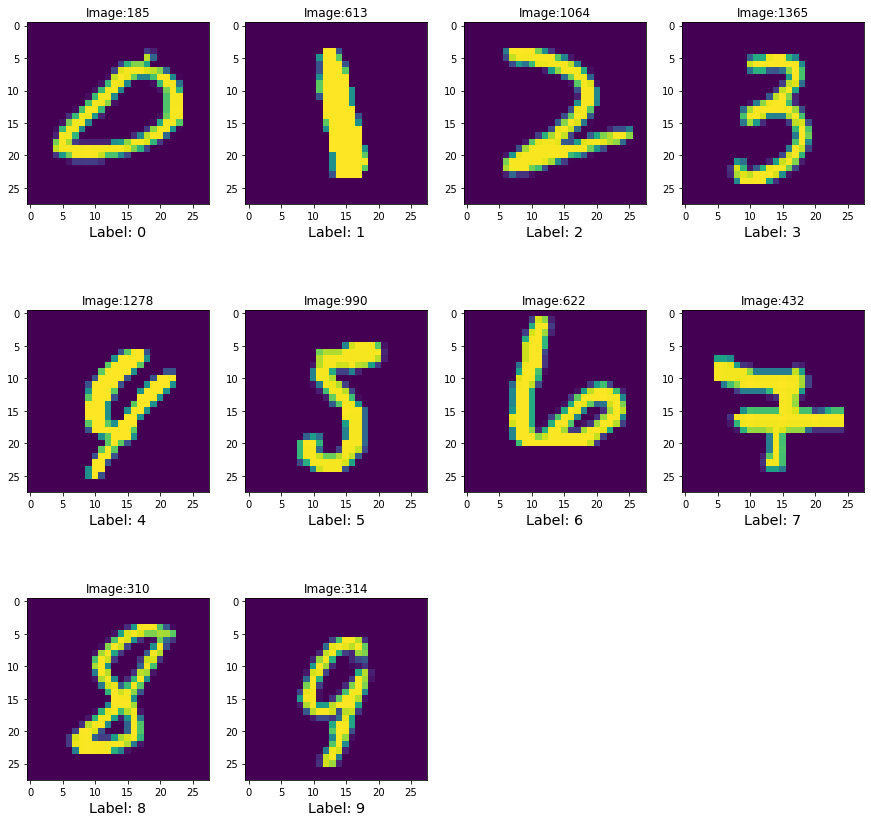

In [69]:
plot_random_images_of_each_label()

In [9]:
df['label'].nunique()

10

In [10]:
df.min().min()

0

In [11]:
df.max().max()

255

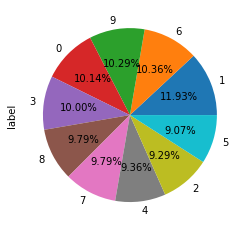

In [12]:
df['label'].value_counts().plot(kind='pie',autopct='%.2f%%')

# Pre processing

In [82]:
normalized_X = X/255.0

Pixels are in range 0-255 so we have to put them in a range for each column between 0-1. 
Works best for SVC and Naive Bayes both

In [94]:
 X_train,X_test, y_train,y_test = train_test_split(normalized_X.values,y,
                                                  stratify=y,
                                                  random_state=SEED,
                                                  test_size=0.20)

# Naive Bayes

In [96]:
ber = BernoulliNB()
bern_params = {'alpha':[0.0001,0.001,0.1,0.25,0.5,0.9],
          'binarize':[None,0.0001,0.001,0.1,0.4,0.8,1.0]
         }

fitted_grid = GridSearchCV(ber,bern_params).fit(X_train,y_train)
fitted_grid.best_params_

In [98]:
fitted_ber = BernoulliNB(alpha=0.001,binarize=0.4).fit(X_train,y_train)
y_pred = fitted_ber.predict(X_test)

acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred,average='macro')
rec = recall_score(y_test,y_pred,average='macro')

print(f'Best model scores are as follows:\n')
print(f'Accuracy: {acc}\nPrecision: {prec}\nRecall:{rec}')

Best modelscores are as follows:

Accuracy: 0.8285714285714286
Precision: 0.8303917106201588
Recall:0.8250168732927354


# SVC & KNN

In [103]:
def run_models(X_train,X_test,y_train,y_test,models_list=None,):
    
    import time 
    
    classifiers = [SVC(random_state=SEED),
                  KNeighborsClassifier(n_jobs=-1)]
    
    if models_list:
         classifiers = models_list

    fitted_clf_lis = []
    
    for clf in classifiers:
        start = time.time()
        
        fitted_clf = clf.fit(X_train,y_train)
        
        time_taken = time.time()-start
        
        y_pred = fitted_clf.predict(X_test)
        
        fitted_clf_lis.append(fitted_clf)
        

        acc = accuracy_score(y_test,y_pred)
        prec = precision_score(y_test,y_pred,average='macro')
        rec = recall_score(y_test,y_pred,average='macro')

        print(f'{type(clf).__name__} has taken {time_taken} seconds and test scores are as follows:\n')
        print(f'Accuracy: {acc}\nPrecision: {prec}\nRecall:{rec}\n','*'*20)
        
    return(fitted_clf_lis)

In [104]:
fitted_models = run_models(X_train,X_test,y_train,y_test)

SVC has taken 0.8280105590820312 seconds and test scores are as follows:

Accuracy: 0.9464285714285714
Precision: 0.9477795037206802
Recall:0.9447638249362387
 ********************
KNeighborsClassifier has taken 0.060454368591308594 seconds and test scores are as follows:

Accuracy: 0.8714285714285714
Precision: 0.8763673263583852
Recall:0.866676139952002
 ********************


## Best SVC

In [111]:
svc = SVC(random_state=SEED)
svc_params = {'C':[0.01,0.1,1,5,10],
        'kernel':['linear','rbf'],
        'degree':[1,2,3]
        }

fitted_grid = GridSearchCV(svc,svc_params).fit(X_train,y_train)
fitted_grid.best_params_

{'C': 5, 'degree': 1, 'kernel': 'rbf'}

## Best KNN

In [110]:
knn = KNeighborsClassifier(n_jobs=-1,)
knn_params = {'n_neighbors':[1,3,5,7,10],
        'p':[1,2],
        }

fitted_grid = GridSearchCV(knn,knn_params).fit(X_train,y_train)
fitted_grid.best_params_

{'n_neighbors': 3, 'p': 2}

### Comparison

In [112]:
model_list = [SVC(random_state=SEED,kernel='rbf',degree=1,C=5),
              KNeighborsClassifier(n_jobs=-1,n_neighbors=3,p=2)]

best_models = run_models(X_train,X_test,y_train,y_test,model_list)

SVC has taken 0.8659791946411133 seconds and test scores are as follows:

Accuracy: 0.9464285714285714
Precision: 0.9471202483222945
Recall:0.9453041530627736
 ********************
KNeighborsClassifier has taken 0.06326889991760254 seconds and test scores are as follows:

Accuracy: 0.8857142857142857
Precision: 0.8911871345171569
Recall:0.8808965938276284
 ********************


SVC is slower but better than KNN